In [1]:
import copy
import re
import pandas as pd
import numpy as np
from experiments import ExperimentModule
from experiments import (
    save_plots, 
    write_row, 
    write_opcounts,
    save_circuit,
    create_dir
)
from sanchez_ansatz import SanchezAnsatz
from qiskit import transpile
from qiskit_algorithms.optimizers import SPSA
import matplotlib.pyplot as plt
from itertools import product
from datetime import datetime

%matplotlib inline

In [2]:
datetime_str = str(datetime.now())
datetime_list = re.findall(r"\d+", datetime_str)
datetime_digits = "".join(datetime_list)

results_dir = f"results/{datetime_digits}"
create_dir(results_dir)

In [4]:
qubit_range = [3, 4, 5, 6, 7, 8]
eps_values = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

In [7]:

for num_qubits, eps in product(qubit_range, eps_values):

    print("--"*50)
    print(f"\t\t Experiments for {num_qubits} qubits and {eps} error")
    print("--"*50)


    state = np.random.rand(2**num_qubits)
    state = state / np.linalg.norm(state)

    ansatz = SanchezAnsatz(state, eps)

    ## Running original
    print("--"*50)
    print("\t\t Running ORIGINAL Method")
    print("--"*50)
    init_params = ansatz.init_params
    t_ansatz = transpile(ansatz, basis_gates=["cx", "u"])

    em_original = ExperimentModule(
                    t_ansatz,
                    SPSA(maxiter=1000),
                    target_state=state,
                    init_params=init_params
                )

    result_original = em_original.minimize()

    ## Running modified
    print("--"*50)
    print("\t\t Running MODIFIED method")
    print("--"*50)
    ansatz = SanchezAnsatz(state, eps, build_modified=True)

    init_params = ansatz.init_params
    t_ansatz = transpile(ansatz, basis_gates=["cx", "u"])

    em_modified = ExperimentModule(
                    t_ansatz,
                    SPSA(maxiter=1000),
                    target_state=state,
                    init_params=init_params
                )

    result_modified = em_modified.minimize()

    # Saving comparison plots
    save_plots(em_original, em_modified, f"{results_dir}/plots/plot_{num_qubits}qb_{eps}eps.pdf")

    # writing csv loss progression
    write_row(em_original._loss_progression, file=f"{results_dir}/csv/original_fidloss_{num_qubits}qb_{eps}eps.csv")
    write_row(em_modified._loss_progression, file=f"{results_dir}/csv/modified_fidloss_{num_qubits}qb_{eps}eps.csv")

    # writing csv best point
    write_row(em_original.result.x, file=f"{results_dir}/csv/original_xbest_{num_qubits}qb_{eps}eps.csv")
    write_row(em_modified.result.x, file=f"{results_dir}/csv/modified_xbest_{num_qubits}qb_{eps}eps.csv")

    # writing op_counts
    write_opcounts(em_original, em_modified, file=f"results/op_counts/counts_{num_qubits}qb_{eps}eps.txt")

    # saving circuits
    save_circuit(em_original._ansatz, file=f"{results_dir}/circuits/original_curcuit_{num_qubits}qb_{eps}eps.pkl")
    save_circuit(em_modified._ansatz, file=f"{results_dir}/circuits/modified_curcuit_{num_qubits}qb_{eps}eps.pkl")

----------------------------------------------------------------------------------------------------
		 Experiments for 3 qubits and 0.5 error
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
		 Running ORIGINAL Method
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
		 Running MODIFIED method
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
		 Experiments for 3 qubits and 0.1 error
----------------------------------------------------------------------------------------------------
------------------------------------------------------

Creating pandas dataframe

Creating result dictionaries

In [52]:
#[0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
original_results_dict = {
    "num_qubits": [],
    0.5: [],
    0.1: [],
    0.05: [],
    0.01: [],
    0.005: [],
    0.001: []
}

modified_results_dict = copy.deepcopy(original_results_dict)

for num_qubits in qubit_range:
    original_results_dict["num_qubits"] += [num_qubits]
    modified_results_dict["num_qubits"] += [num_qubits]

    for eps in eps_values:
        fid_loss_original = np.loadtxt(f"{results_dir}/csv/original_fidloss_{num_qubits}qb_{eps}eps.csv", delimiter=",")
        data_original = fid_loss_original[-1][-1] if len(fid_loss_original.shape) > 1 else fid_loss_original[-1]
        original_results_dict[eps]+= [round(data_original,4)]

        fid_loss_modified = np.loadtxt(f"{results_dir}/csv/modified_fidloss_{num_qubits}qb_{eps}eps.csv", delimiter=",")
        data_modified = fid_loss_modified[-1][-1] if len(fid_loss_modified.shape) > 1 else fid_loss_modified[-1]
        modified_results_dict[eps]+= [round(data_modified, 4)]

Original fidloss

In [53]:
df_original = pd.DataFrame(original_results_dict)
df_original=df_original.set_index("num_qubits")
df_original

,0.5,0.1,0.05,0.01,0.005,0.001
num_qubits,,,,,,
3,0.1053,0.2938,0.2980,0.0409,0.1660,0.0549
4,0.1237,0.0797,0.1904,0.0661,0.0758,0.1348
5,0.1138,0.1181,0.2441,0.1511,0.2545,0.1324
6,0.2392,0.1810,0.2119,0.2336,0.1597,0.1220
7,0.2358,0.4956,0.2160,0.2333,0.2251,0.2017
8,0.3404,0.2600,0.2433,0.2555,0.2560,0.2863


Modified fidloss

In [55]:
df_modified = pd.DataFrame(modified_results_dict)
df_modified = df_modified.set_index("num_qubits")
df_modified

,0.5,0.1,0.05,0.01,0.005,0.001
num_qubits,,,,,,
3,0.0727,0.3125,0.3071,0.0409,0.1660,0.0549
4,0.1175,0.0604,0.1409,0.0661,0.0770,0.1224
5,0.0694,0.0882,0.2162,0.1486,0.2545,0.1354
6,0.3684,0.1190,0.1645,0.2243,0.1565,0.1136
7,0.7005,0.4584,0.6266,0.2619,0.3026,0.2032
8,0.6130,0.5276,0.4664,0.2265,0.2465,0.2374


In [51]:
abs(df_original -df_modified)/(df_original + df_modified)

,0.5,0.1,0.05,0.01,0.005,0.001
num_qubits,,,,,,
3,0.183146,0.030843,0.015039,0.000000,0.000000,0.000000
4,0.025705,0.137759,0.149411,0.000000,0.007853,0.048212
5,0.242358,0.144935,0.060613,0.008342,0.000000,0.011202
6,0.212640,0.206667,0.125930,0.020310,0.010120,0.035654
7,0.496315,0.038994,0.487301,0.057754,0.146864,0.003705
8,0.285924,0.339766,0.314358,0.060166,0.018905,0.093374


Counting depth

In [5]:
depth_count_original = []
depth_count_modified = []

for qb_idx, num_qubits in enumerate(qubit_range):
    depth_count_original += [[]]
    depth_count_modified += [[]]

    for eps in eps_values:
        #circuit = load_circuit(f"results/circuits/curcuit_{num_qubits}qb_{eps}eps.pkl")
        state = np.random.rand(2**num_qubits)
        state = state / np.linalg.norm(state)

        # original
        ansatz = SanchezAnsatz(state, eps)
        to_ansatz = transpile(ansatz, basis_gates=["cx", "u"])
        depth_count_original[qb_idx] += [to_ansatz.depth()]

        # modified
        mod_ansatz = SanchezAnsatz(state, eps, build_modified=True)
        tm_ansatz = transpile(mod_ansatz, basis_gates=["cx", "u"])
        depth_count_modified[qb_idx] += [tm_ansatz.depth()]


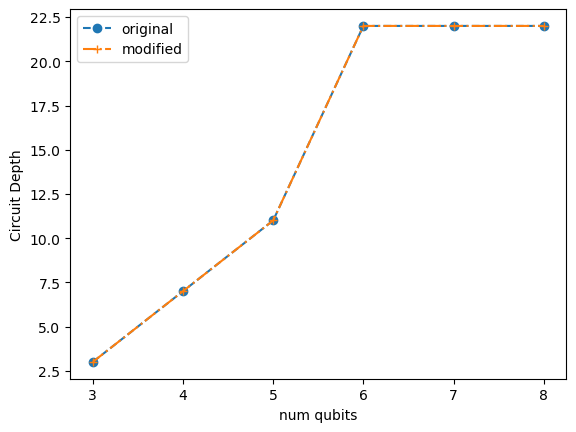

In [6]:
mean_depth_original = np.mean(depth_count_original, axis=1, dtype=np.int32)
mean_depth_modified = np.mean(depth_count_modified, axis=1, dtype=np.int32)

plt.plot(qubit_range, mean_depth_original, "--", marker="o", label='original')
plt.plot(qubit_range, mean_depth_modified, "-.", marker="+", label="modified")
plt.xlabel("num qubits")
plt.ylabel("Circuit Depth")
plt.legend(loc="best")
plt.plot()
plt.savefig("results/mean_circuit_depth.pdf")